In [2]:
import numpy as np
from functions import *
from schemes import *
from plot import * 

In [3]:
# gravity
G = 1

# masses
m1 = 1
m2 = 1 

# position
r1 = np.array([0,0.0,0.0], dtype="float64")
r2 = np.array([1.0,0.0,0.0], dtype="float64")

# velocity 
v1 = np.array([0,0.0,0], dtype="float64")
v2 = np.array([0,1.0,0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2])
v0s = np.array([v1,v2])
masses = np.array([m1, m2])

# reposition centre of mass to origin with no momentum 
rcom, vcom = CentreOfMass(r0s, v0s, masses)
r0s -= rcom
v0s -= vcom

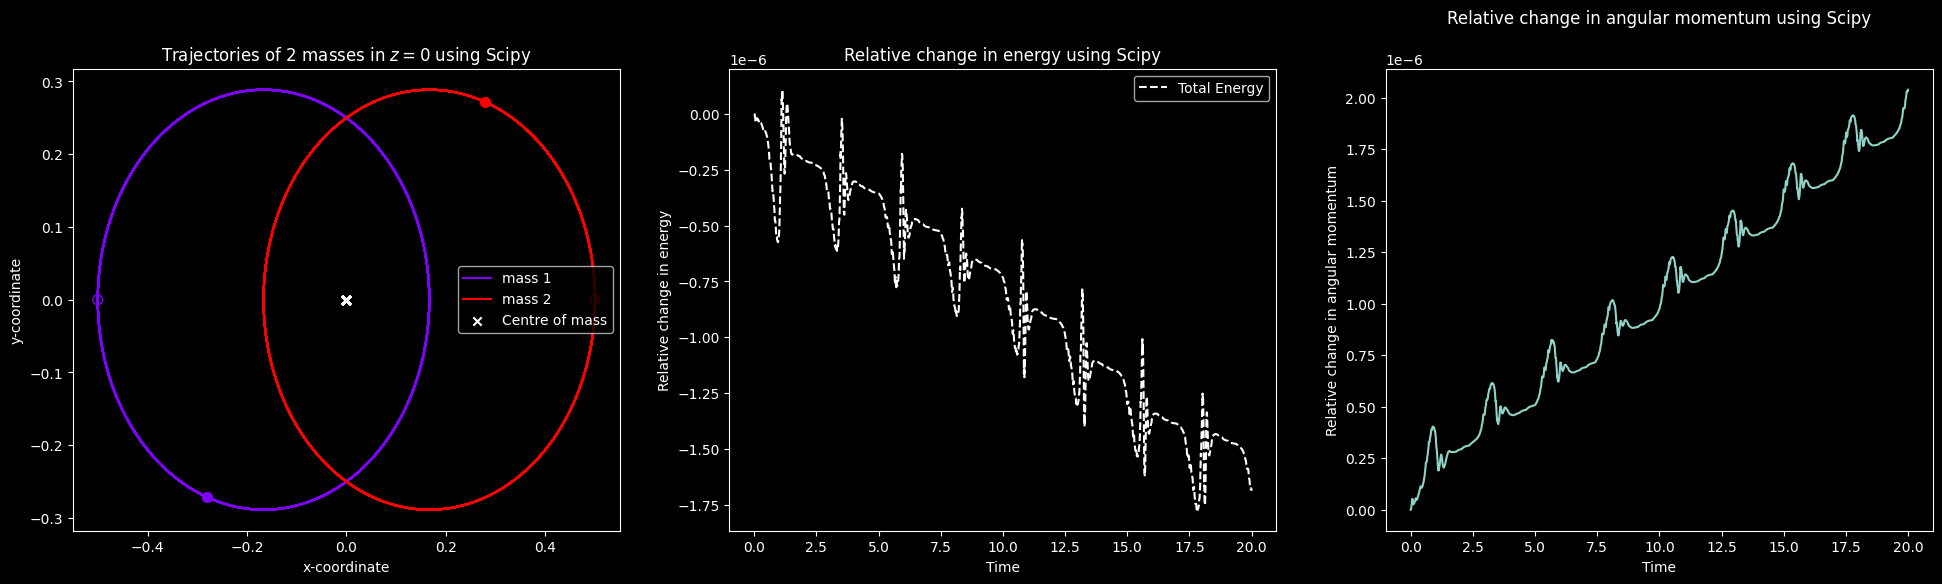

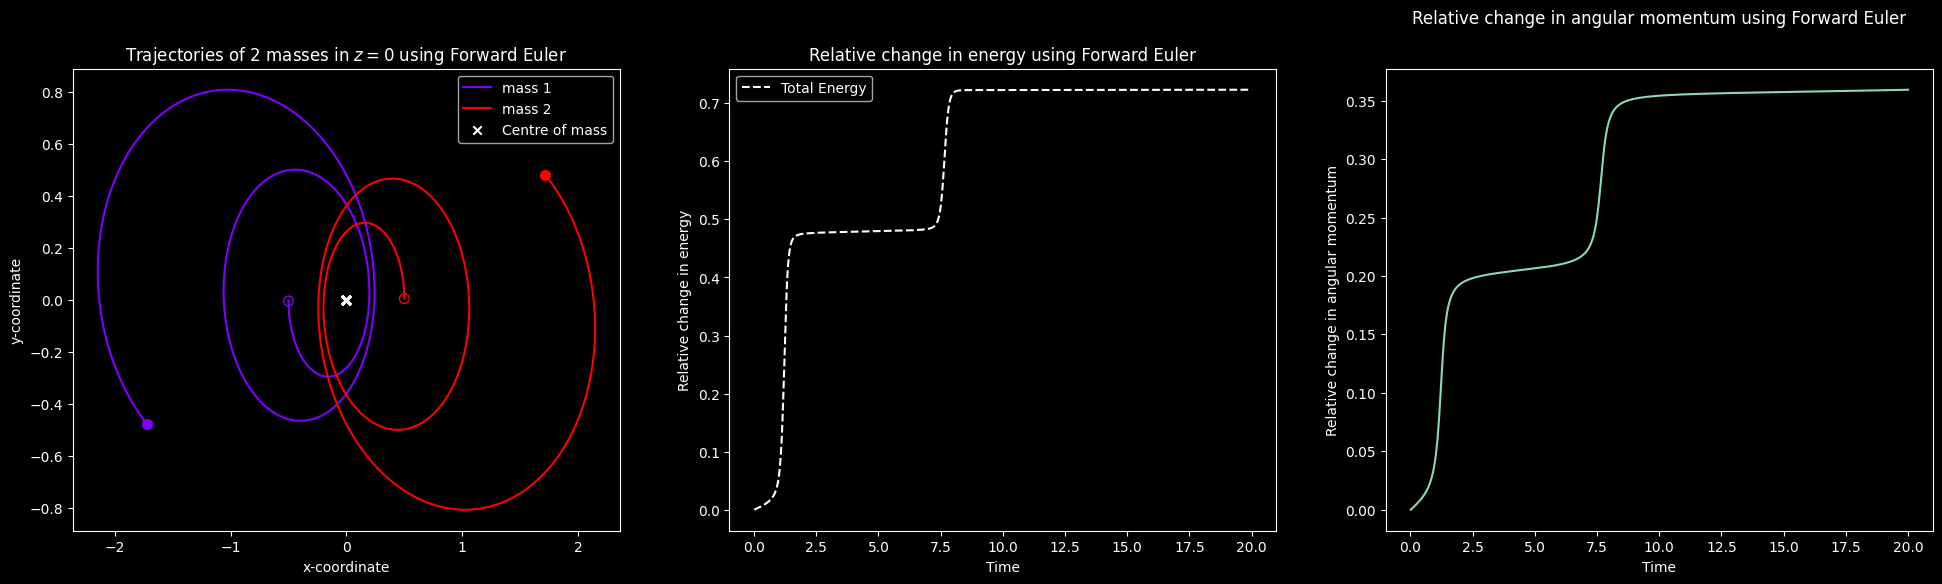

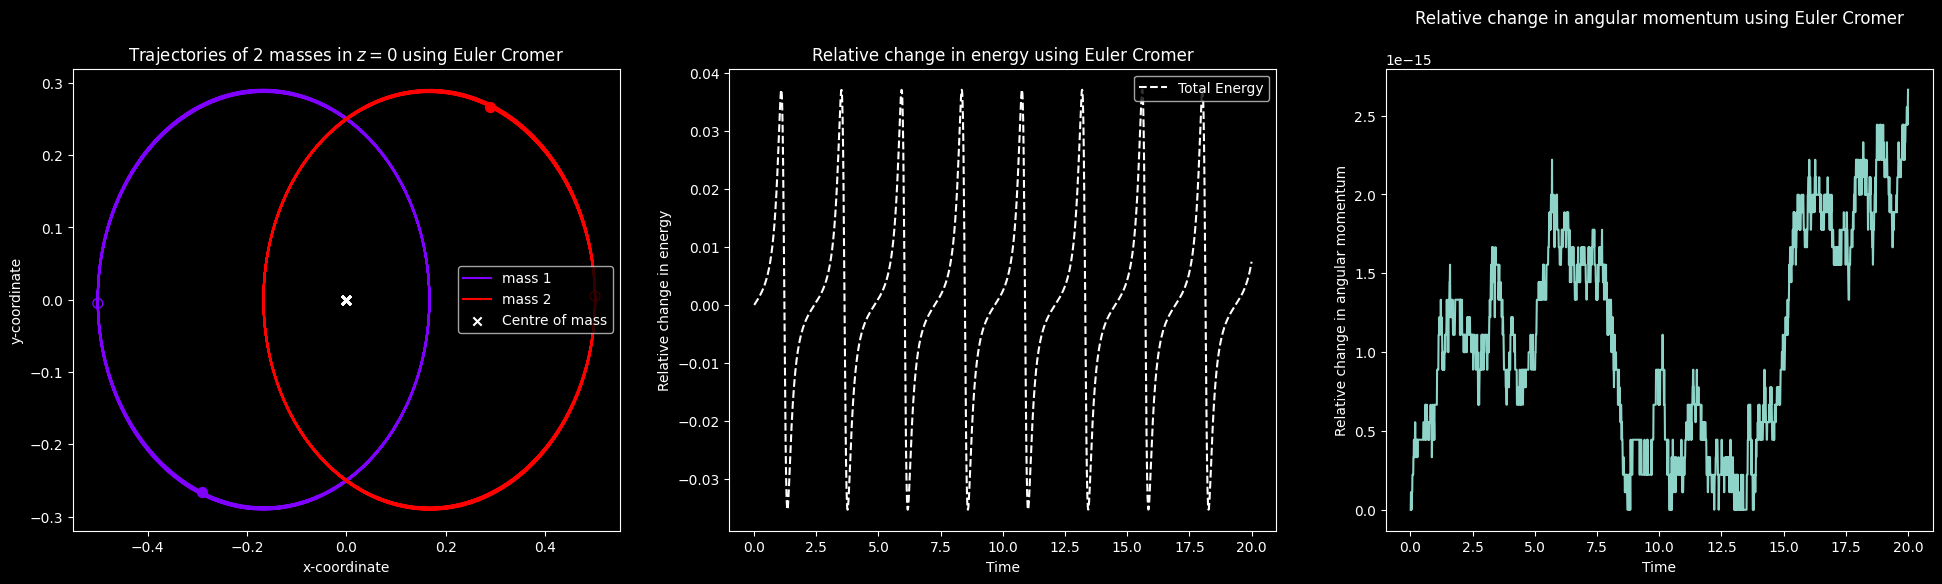

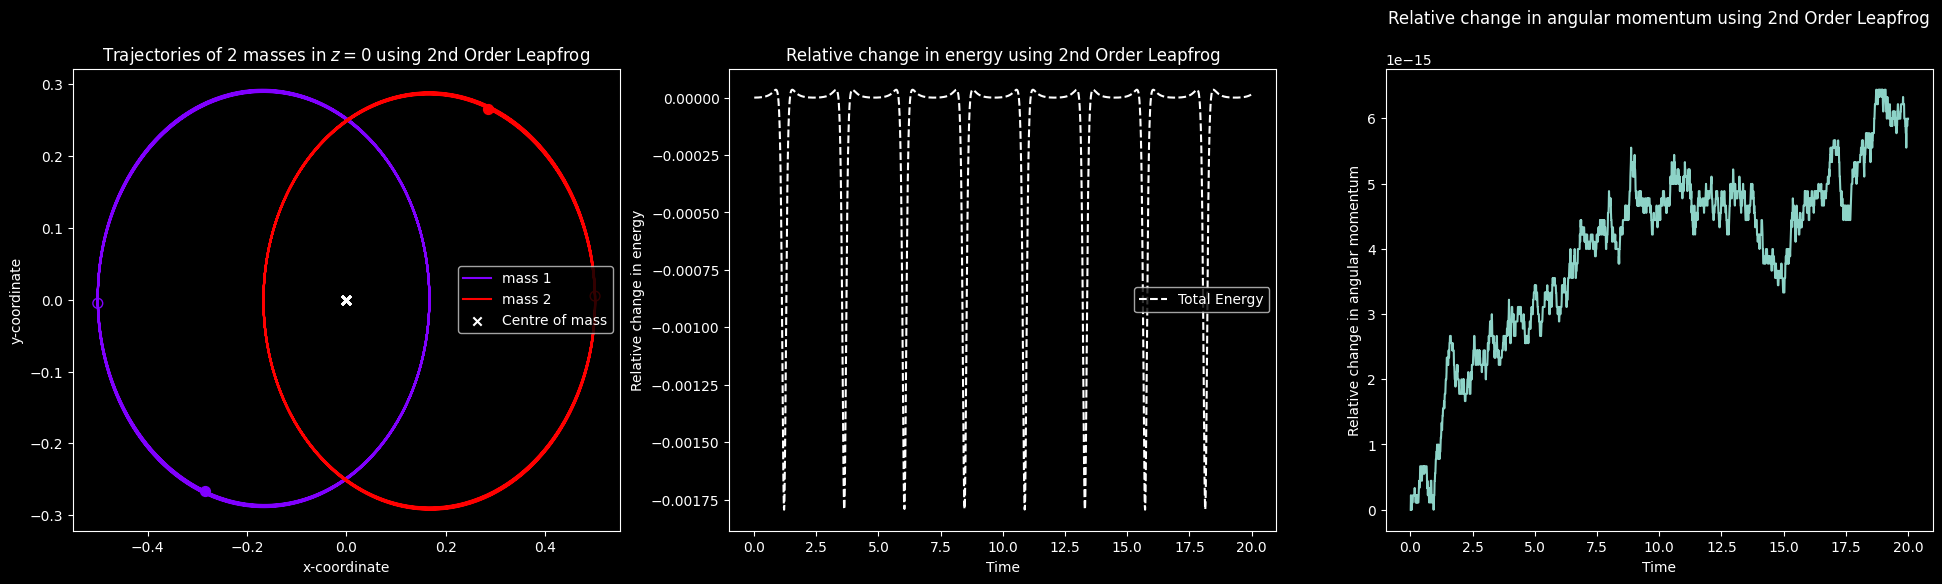

In [4]:
### Truth ###
t_vals, true_rs, true_vs, true_ke, true_pe, true_am = run_scipy(0, 20, 0.01, r0s, v0s, G, masses)
plot2D(t_vals, true_rs, true_vs, true_ke, true_pe, true_am, masses, 'Scipy')

### Forward Euler ###
Euler_ts, Euler_rs, Euler_vs, Euler_ke, Euler_pe, Euler_am = run_scheme(EulerStep, 0, 20, 0.01, r0s, v0s, G, masses)
plot2D(Euler_ts, Euler_rs, Euler_vs, Euler_ke, Euler_pe, Euler_am, masses, 'Forward Euler')

# ### Euler Cromer ###
EulerCromer_ts, EulerCromer_rs, EulerCromer_vs, EulerCromer_ke, EulerCromer_pe, EulerCromer_am = run_scheme(EulerCromerStep, 0, 20, 0.01, r0s, v0s, G, masses)
plot2D(EulerCromer_ts, EulerCromer_rs, EulerCromer_vs, EulerCromer_ke, EulerCromer_pe, EulerCromer_am, masses, 'Euler Cromer')

# ### 2nd Order Leapfrog ###
Leapfrog_ts, Leapfrog_rs, Leapfrog_vs, Leapfrog_ke, Leapfrog_pe, Leapfrog_am = run_scheme(LeapfrogStep, 0, 20, 0.01, r0s, v0s, G, masses)
plot2D(Leapfrog_ts, Leapfrog_rs, Leapfrog_vs, Leapfrog_ke, Leapfrog_pe, Leapfrog_am, masses, '2nd Order Leapfrog')
